# Analysis of `wandb` Logs and Metrics
This notebook collects different metrics for a specified experiment.

# Setup

In [1]:
import numpy as np
import pprint
from typing import Literal, List

import warnings

warnings.filterwarnings("ignore")

import wandb

api = wandb.Api()

import pandas as pd


In [2]:
runs = api.runs("uedyiuajxz-personal/qfl-prod-le-2")

In [3]:
groups = list(set(run.config.get("group", None) for run in runs))
print(groups)

['FHE-resnet18-14096299', 'Standard-fedqnn-14166516', 'FHE-resnet18-14378201', 'Standard-fednn-14378194', 'Standard-resnet18-qcnn-14385583', 'FHE-resnet18-qcnn-14629774', 'Standard-resnet18-14166520', 'Standard-qcnn-14385577', 'FHE-qcnn-14288056', 'Standard-fednn-14288051', 'FHE-resnet18-qcnn-14602070', 'Standard-resnet18-qnn-14385581', 'FHE-fedqnn-14288054', 'Standard-qcnn-14378198', 'FHE-resnet18-qnn-14096301', 'Standard-fedqnn-14385575', 'FHE-resnet18-14385580', 'FHE-resnet18-14288058', 'Standard-resnet18-qnn-14288059', 'FHE-resnet18-qnn-14378203', 'Standard-resnet18-qnn-14166522', 'Standard-resnet18-14096298', 'Standard-qcnn-14096296', 'Standard-resnet18-qcnn-14378204', 'Standard-qcnn-14166518', 'Standard-resnet18-qcnn-14096302', 'FHE-resnet18-qcnn-14568056', 'FHE-resnet18-14166521', 'FHE-qcnn-14378199', 'Standard-resnet18-qcnn-14166524', 'FHE-fednn-14378195', 'FHE-fednn-14288052', 'FHE-qcnn-14385578', 'Standard-resnet18-qnn-14378202', 'Standard-fednn-14166514', 'Standard-resnet18-

# EDA

In [4]:
group_in_focus = groups[0]

In [5]:
grouped_runs = [run for run in runs if run.config.get("group", None) == group_in_focus]
server = None
clients = []

for run in grouped_runs:
    participant = run.config.get("participant", None)
    if participant == "server":
        server = run
    else:
        clients.append(run)
    print(f"Run ID: {run.id}, Name: {run.name}, Type: {participant}")

Run ID: xgql4kx2, Name: server, Type: server
Run ID: 09lkvqdd, Name: client11, Type: client11
Run ID: 0zr71x57, Name: client19, Type: client19
Run ID: 2u6y47vd, Name: client4, Type: client4
Run ID: 8aey8j68, Name: client13, Type: client13
Run ID: 92goa2g1, Name: client5, Type: client5
Run ID: ce35et1j, Name: client9, Type: client9
Run ID: kt8rrupt, Name: client14, Type: client14
Run ID: m04i6ulv, Name: client16, Type: client16
Run ID: npglpo4f, Name: client12, Type: client12
Run ID: o9y7d041, Name: client18, Type: client18
Run ID: on616wvh, Name: client15, Type: client15
Run ID: psuutlp2, Name: client2, Type: client2
Run ID: qrysicjc, Name: client0, Type: client0
Run ID: t4n7qhjt, Name: client6, Type: client6
Run ID: tmiu0bds, Name: client17, Type: client17
Run ID: v313n9jy, Name: client3, Type: client3
Run ID: vugn2f3a, Name: client7, Type: client7
Run ID: wlgtlm7c, Name: client1, Type: client1
Run ID: y50vwcxc, Name: client8, Type: client8
Run ID: xdfhgo9t, Name: client10, Type: clie

## Settings

In [6]:
pp = pprint.PrettyPrinter(indent=1, width=40)
pp.pprint(server.config)

{'batch_size': 32,
 'dataset': 'MRI',
 'fhe_enabled': True,
 'group': 'FHE-resnet18-14096299',
 'learning_rate': '1e-3',
 'model': 'resnet18',
 'number_clients': 20,
 'participant': 'server',
 'rounds': 20}


## Server and Aggregated Metrics

In [7]:
def compute_statistics(arr: np.ndarray) -> dict:
    """
    Compute basic statistical measures of an array, including mean, median, standard deviation,
    25th percentile (Q1), and 75th percentile (Q3).

    Parameters
    ----------
    arr : np.ndarray
        Input numerical array.

    Returns
    -------
    dict
        A dictionary containing the following statistics:
        - "mean" : float
            The average of the array.
        - "median" : float
            The middle value of the array.
        - "std" : float
            The standard deviation (sample standard deviation with `ddof=1`).
        - "25%" : float
            The 25th percentile (Q1).
        - "75%" : float
            The 75th percentile (Q3).

    Examples
    --------
    >>> import numpy as np
    >>> data = np.array([10, 20, 30, 40, 50, 60, 70, 80, 90, 100])
    >>> compute_statistics(data)
    {'mean': 55.0, 'median': 55.0, 'std': 30.276503540974915, '25%': 32.5, '75%': 77.5}
    """
    if not isinstance(arr, np.ndarray):
        arr = np.array(arr)

    stats = {
        "mean": np.mean(arr),
        "median": np.median(arr),
        "std": np.std(arr, ddof=1),
        "25%": np.percentile(arr, 25),
        "75%": np.percentile(arr, 75),
        "min": np.min(arr),
        "max": np.max(arr),
        "last_value": arr[-1],
    }
    return stats

In [8]:
from rich.console import Console
from rich.table import Table

console = Console()

# Create Table 1 (Basic Stats: Mean, Median, Std)
table1 = Table(title="Server Statistics (Part 1)")
table1.add_column("Metric", justify="left", style="cyan", min_width=20)
table1.add_column("Mean", justify="right", style="green", min_width=12)
table1.add_column("Median", justify="right", style="green", min_width=12)
table1.add_column("Std", justify="right", style="green", min_width=12)

# Create Table 2 (Percentiles + Min/Max/Last Value)
table2 = Table(title="Server Statistics (Part 2)")
table2.add_column("Metric", justify="left", style="cyan", min_width=20)
table2.add_column("25%", justify="right", style="green", min_width=12)
table2.add_column("75%", justify="right", style="green", min_width=12)
table2.add_column("Max", justify="right", style="green", min_width=12)
table2.add_column("Min", justify="right", style="green", min_width=12)
table2.add_column("Last", justify="right", style="green", min_width=12)

server_history = server.history()
for metric in server_history.keys():
    metric_values = [val for val in server_history[metric] if not np.isnan(val)]
    stats = compute_statistics(metric_values)

    # Add row to Table 1
    table1.add_row(
        metric, f"{stats['mean']:.2f}", f"{stats['median']:.2f}", f"{stats['std']:.2f}"
    )

    # Add row to Table 2
    table2.add_row(
        metric,
        f"{stats['25%']:.2f}",
        f"{stats['75%']:.2f}",
        f"{stats['max']:.2f}",
        f"{stats['min']:.2f}",
        f"{stats['last_value']:.2f}",
    )


console.print(table1)
console.print(table2)

                            Server Statistics (Part 1)                             
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┓
┃ Metric                     ┃            Mean ┃          Median ┃            Std ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━┩
│ Total Bytes Sent           │   2557700745.50 │   2557700745.50 │  1592790626.64 │
│ total_training_time        │        23776.64 │        23776.64 │            nan │
│ metrics_agg.precisions     │            0.89 │            0.90 │           0.02 │
│ _runtime                   │        12454.13 │        12495.64 │        7623.38 │
│ metrics_agg.f1s            │            0.89 │            0.90 │           0.02 │
│ Bytes Sent (Round)         │    255769645.90 │    269230755.00 │    60199910.00 │
│ parameter_aggregation_time │           57.00 │           55.67 │           3.48 │
│ metrics_agg.accuracy       │           89.27 │           90.02 │           1.66 │
│ _step                      │           10.50 │           10.50 │           6.49 │
│ Bytes Received (Round)     │  13718717245.05 │  13718711305.50 │       44796.63 │
│ metrics_agg.recalls        │            0.89 │            0.90 │           0.02 │
│ round                      │           10.50 │           10.50 │           5.92 │
│ _timestamp                 │   1747732535.20 │   1747732576.72 │        7623.36 │
│ round_time                 │         1107.03 │         1106.48 │           3.80 │
│ Total Bytes Received       │ 144046488978.50 │ 144046436850.00 │ 81161049941.66 │
│ trainable_parameters       │         2052.00 │         2052.00 │            nan │
│ loss_agg                   │            0.31 │            0.30 │           0.04 │
└────────────────────────────┴─────────────────┴─────────────────┴────────────────┘

                                            Server Statistics (Part 2)                                             
┏━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Metric                  ┃            25% ┃             75% ┃             Max ┃            Min ┃            Last ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ Total Bytes Sent        │  1278854659.25 │   3836546831.75 │   5115392918.00 │        8573.00 │   5115392918.00 │
│ total_training_time     │       23776.64 │        23776.64 │        23776.64 │       23776.64 │        23776.64 │
│ metrics_agg.precisions  │           0.89 │            0.90 │            0.91 │           0.85 │            0.91 │
│ _runtime                │        6267.27 │        18751.66 │        23780.16 │           3.34 │        23780.16 │
│ metrics_agg.f1s         │           0.89 │            0.90 │            0.91 │           0.85 │            0.91 │
│ Bytes Sent (Round)      │   269230755.00 │    269230755.00 │    269230755.00 │        8573.00 │    269230755.00 │
│ parameter_aggregation_… │          55.56 │           56.32 │           68.03 │          55.03 │           55.63 │
│ metrics_agg.accuracy    │          88.90 │           90.29 │           90.73 │          84.67 │           90.73 │
│ _step                   │           5.25 │           15.75 │           21.00 │           0.00 │           21.00 │
│ Bytes Received (Round)  │ 13718691393.25 │  13718736294.00 │  13718802599.00 │ 13718637068.00 │  13718725961.00 │
│ metrics_agg.recalls     │           0.89 │            0.90 │            0.91 │           0.85 │            0.91 │
│ round                   │           5.75 │           15.25 │           20.00 │           1.00 │           20.00 │
│ _timestamp              │  1747726348.35 │   1747738832.74 │   1747743861.10 │  1747720084.43 │   1747743861.10 │
│ round_time              │        1105.82 │         1108.66 │         1114.37 │        1100.43 │         1105.91 │
│ Total Bytes Received    │ 78882513386.75 │ 209210440388.75 │ 274374344901.00 │ 13718712619.00 │ 274374344901.00 │
│ trainable_parameters    │        2052.00 │         2052.00 │         2052.00 │        2052.00 │         2052.00 │
│ loss_agg                │           0.29 │            0.31 │            0.43 │           0.29 │            0.29 │
└─────────────────────────┴────────────────┴─────────────────┴─────────────────┴────────────────┴─────────────────┘

## Client Metrics

In [9]:
def compute_client_statistics(client_histories):
    """
    Computes statistics for each metric by merging values across all clients.

    Parameters
    ----------
    client_histories : list[dict]
        A list of dictionaries where each dictionary contains metric history for a single client.

    Returns
    -------
    dict
        A dictionary where each key is a metric name and the value is its computed statistics.
    """
    merged_metrics = {}

    # Iterate through all client histories
    for client_history in client_histories:
        for metric, values in client_history.items():
            # Remove NaN values and flatten lists
            cleaned_values = [val for val in values if not np.isnan(val)]

            # Merge values from all clients
            if metric not in merged_metrics:
                merged_metrics[metric] = []
            merged_metrics[metric].extend(cleaned_values)

    # Compute statistics for each metric
    stats_dict = {
        metric: compute_statistics(np.array(values))
        for metric, values in merged_metrics.items()
    }

    return stats_dict


# Example: Fetch history from multiple clients
client_histories = [
    client.history() for client in clients
]  # Replace with actual client list

# Compute merged statistics
merged_stats = compute_client_statistics(client_histories)

# Display results using rich
console = Console()

# Create Table 1 (Basic Stats: Mean, Median, Std)
table1 = Table(title="Merged Client Metrics Statistics (Part 1)")
table1.add_column("Metric", justify="left", style="cyan", min_width=20)
table1.add_column("Mean", justify="right", style="green", min_width=12)
table1.add_column("Median", justify="right", style="green", min_width=12)
table1.add_column("Std", justify="right", style="green", min_width=12)

# Create Table 2 (Percentiles + Min/Max/Last Value)
table2 = Table(title="Merged Client Metrics Statistics (Part 2)")
table2.add_column("Metric", justify="left", style="cyan", min_width=20)
table2.add_column("25%", justify="right", style="green", min_width=12)
table2.add_column("75%", justify="right", style="green", min_width=12)
table2.add_column("Max", justify="right", style="green", min_width=12)
table2.add_column("Min", justify="right", style="green", min_width=12)
table2.add_column("Last", justify="right", style="green", min_width=12)

# Populate table with computed statistics
for metric, stats in merged_stats.items():
    table1.add_row(
        metric, f"{stats['mean']:.2f}", f"{stats['median']:.2f}", f"{stats['std']:.2f}"
    )

    # Add row to Table 2
    table2.add_row(
        metric,
        f"{stats['25%']:.2f}",
        f"{stats['75%']:.2f}",
        f"{stats['max']:.2f}",
        f"{stats['min']:.2f}",
        f"{stats['last_value']:.2f}",
    )

# Display table
console.print(table1)
console.print(table2)

                 Merged Client Metrics Statistics (Part 1)                 
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┓
┃ Metric                   ┃          Mean ┃        Median ┃          Std ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━┩
│ client_round_time        │       1060.08 │       1065.70 │        27.48 │
│ _step                    │      12874.38 │       3785.50 │     15628.70 │
│ _runtime                 │       5888.55 │         43.69 │      8004.37 │
│ _timestamp               │ 1747738735.28 │ 1747744371.60 │      7856.10 │
│ decryption_time          │          1.43 │          1.51 │         0.34 │
│ encryption_time          │          1.53 │          1.20 │         1.03 │
│ client_real_memory_mb    │       4178.38 │       4221.58 │       729.90 │
│ server_real_memory_mb    │      50276.69 │      51938.28 │     11287.17 │
│ client_virtual_memory_mb │      16394.93 │      16613.33 │      1534.95 │
│ server_virtual_memory_mb │      66979.15 │      68886.45 │     12357.09 │
│ client_cpu_percentage    │        210.89 │        188.55 │       159.34 │
│ server_cpu_percentage    │         27.25 │          0.00 │       161.75 │
└──────────────────────────┴───────────────┴───────────────┴──────────────┘

                                 Merged Client Metrics Statistics (Part 2)                                  
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Metric                   ┃           25% ┃           75% ┃           Max ┃           Min ┃          Last ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ client_round_time        │       1047.58 │       1082.10 │       1100.41 │        948.24 │       1059.06 │
│ _step                    │         11.00 │      26147.00 │      47901.00 │          0.00 │      47901.00 │
│ _runtime                 │         22.20 │      11731.57 │      23719.42 │          1.06 │         47.50 │
│ _timestamp               │ 1747733172.56 │ 1747744393.40 │ 1747744414.45 │ 1747720149.02 │ 1747744414.45 │
│ decryption_time          │          1.41 │          1.57 │          1.91 │          0.00 │          1.52 │
│ encryption_time          │          0.96 │          1.64 │          8.28 │          0.68 │          1.31 │
│ client_real_memory_mb    │       4092.91 │       4339.72 │       6192.76 │         58.10 │       3446.20 │
│ server_real_memory_mb    │      51136.56 │      51940.80 │      65797.83 │         68.00 │      38045.81 │
│ client_virtual_memory_mb │      16474.23 │      16687.77 │      18550.06 │       1720.90 │      15843.19 │
│ server_virtual_memory_mb │      68054.48 │      68886.50 │      82744.99 │       1749.81 │      54902.27 │
│ client_cpu_percentage    │         99.90 │        286.05 │       1222.60 │          0.00 │          0.00 │
│ server_cpu_percentage    │          0.00 │          0.00 │       1440.70 │          0.00 │          0.00 │
└──────────────────────────┴───────────────┴───────────────┴───────────────┴───────────────┴───────────────┘

## Other Computations

In [10]:
some_client = clients[0]
history = some_client.history()
metric_values = [val for val in history["client_round_time"] if not np.isnan(val)]
sum(metric_values)

21178.352103948593

# Visuals and Stats for Thesis
## Globals

In [11]:
COLOR = "#A9A9A9"
KEY_ORDER = [
    "Standard-fednn",
    "FHE-fednn",
    "Standard-fedqnn",
    "FHE-fedqnn",
    "Standard-qcnn",
    "FHE-qcnn",
    "Standard-resnet18",
    "FHE-resnet18",
    "Standard-resnet18-qnn",
    "FHE-resnet18-qnn",
    "Standard-resnet18-qcnn",
    "FHE-resnet18-qcnn"
]

## Training and Round Times
### Training Times

In [12]:
def get_dataframe_from_metrics_data(metrics: dict, metric_label: str) -> pd.DataFrame:
    data = []
    for client, samples in metrics.items():
        for sample in samples:
            data.append({"Model": client, metric_label: sample})
    return pd.DataFrame(data)

def get_metric_by_model_type(
        runs: List[wandb.apis.public.runs.Run],
        groups: List[str],
        metric_type: Literal["server_metric", "client_metric", "system_metric"],
        metric: str
    ) -> dict:
    metrics = {}
    for group in groups:
        try:
            if (metric in ["encryption_time", "decryption_time"]) and ("FHE" not in group):
                continue
            grouped_runs = [run for run in runs if run.config.get("group", None) == group]
            history = None
            for run in grouped_runs:
                if metric_type == "system_metric" and run.name == "system_logs":
                    history = run.history()
                elif metric_type == "server_metric" and run.config.get("participant", "") == "server":
                    history = run.history()
                elif metric_type == "client_metric" and "client" in run.config.get("participant", ""):
                    history = run.history()
                else:
                    continue

                metric_values = [
                    val
                    for val in history[metric]
                    if not np.isnan(val)
                ]

                model = "-".join(group.split("-")[:-1])
                if model in metrics.keys():
                    metrics[model] = metrics[model] + metric_values
                else:
                    metrics[model] = metric_values
        except KeyError:
            print(f"Somehow parameter was not found for group {group}.")
            continue

    metrics = {k: metrics[k] for k in KEY_ORDER if k in metrics.keys()}
    return metrics

In [13]:
training_times = get_metric_by_model_type(runs, groups, "server_metric", "total_training_time")

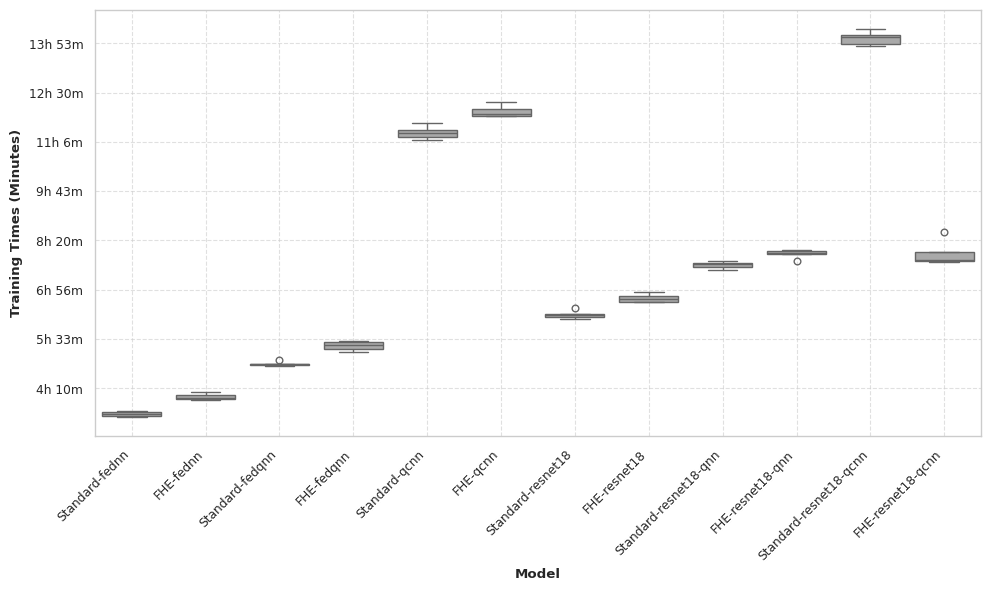

Model Training Times (Minutes)                         \
                                              count        mean        std   
6           Standard-fednn                 0.083333  206.397414   4.198245   
0                FHE-fednn                 0.083333  235.924622   5.473660   
7          Standard-fedqnn                 0.083333  291.824683   3.992422   
1               FHE-fedqnn                 0.083333  321.866503   7.601587   
9        Standard-resnet18                 0.083333  374.639014   6.709202   
3             FHE-resnet18                 0.083333  402.297008   7.237238   
11   Standard-resnet18-qnn                 0.083333  458.479619   5.980606   
5         FHE-resnet18-qnn                 0.083333  477.396852   6.979638   
4        FHE-resnet18-qcnn                 0.083333  477.865162  21.429522   
8            Standard-qcnn                 0.083333  682.231256  11.585660   
2                 FHE-qcnn                 0.083333  718.046793   9.871768   
10  Standard-resnet18-qcnn                 0.083333  842.036664  11.201412   

                                                                
           min         25%         50%         75%         max  
6   201.791917  202.861942  206.059314  210.033102  211.240794  
0   230.653374  232.020477  234.180645  238.723706  244.044909  
7   288.200825  290.014760  290.946286  291.330004  298.631538  
1   311.477119  317.176311  322.951576  327.839327  329.888180  
9   367.481466  370.470732  374.291951  375.827895  385.123029  
3   395.458787  396.277331  401.146677  405.621841  412.980402  
11  449.937233  455.142418  460.389549  461.788662  465.140230  
5   465.852546  476.526360  479.203318  481.894498  483.507539  
4   463.219603  464.729365  466.630637  480.602266  514.143941  
8   669.136421  674.460103  682.090369  686.239302  699.230087  
2   709.860702  711.043893  714.054688  721.560319  733.714363  
10  829.752540  832.533730  843.752443  846.766217  857.378388

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FuncFormatter


def format_time(seconds, _):
    if seconds < 60:
        return f"{int(seconds)}s"
    elif seconds < 3600:
        minutes = seconds // 60
        seconds = seconds % 60
        return f"{int(minutes)}m {int(seconds)}s"
    else:
        hours = seconds // 3600
        minutes = (seconds % 3600) // 60
        return f"{int(hours)}h {int(minutes)}m"

def display_boxplot(metrics_df: pd.DataFrame, metric_label: str, formatter: FuncFormatter = None):
    sns.set_theme(style="whitegrid", context="paper")

    fig, ax = plt.subplots(figsize=(10, 6))
    sns.boxplot(x="Model", y=metric_label, data=metrics_df, color=COLOR)

    plt.xticks(rotation=45, ha="right")
    plt.xlabel("Model", fontweight="bold")
    plt.ylabel(metric_label, fontweight="bold")
    plt.grid(True, linestyle="--", alpha=0.6)


    if formatter:
        ax.yaxis.set_major_formatter(FuncFormatter(formatter))
    # Display the plot
    plt.tight_layout()
    plt.show()

metric_label = "Training Times (Minutes)"
df = get_dataframe_from_metrics_data(training_times, metric_label)
display_boxplot(df, metric_label, format_time)
stats = (df.groupby("Model").describe() / 60).reset_index().sort_values((metric_label,  'mean'))
stats

### Client Round Times

In [15]:
client_round_times = get_metric_by_model_type(runs, groups, "client_metric", "client_round_time")

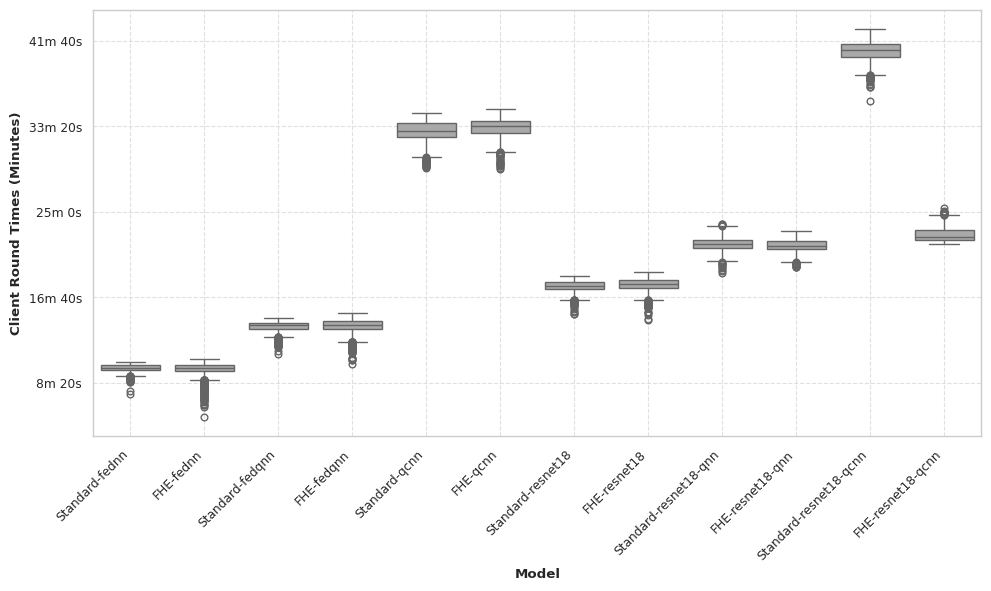

Model Client Round Times (Minutes)                       \
                                                  count       mean       std   
0                FHE-fednn                    33.333333   9.687771  0.625660   
6           Standard-fednn                    33.333333   9.818193  0.300696   
7          Standard-fedqnn                    33.333333  13.876930  0.465222   
1               FHE-fedqnn                    33.333333  13.891874  0.674002   
9        Standard-resnet18                    33.333333  17.762128  0.533725   
3             FHE-resnet18                    33.333333  17.904327  0.632366   
5         FHE-resnet18-qnn                    33.333333  21.712455  0.540821   
11   Standard-resnet18-qnn                    33.333333  21.868296  0.623483   
4        FHE-resnet18-qcnn                     1.666667  22.996932  0.962389   
8            Standard-qcnn                    33.333333  32.948752  0.987532   
2                 FHE-qcnn                    33.333333  33.264183  0.955408   
10  Standard-resnet18-qcnn                    33.333333  40.713777  0.856305   

                                                           
          min        25%        50%        75%        max  
0    5.038325   9.486892   9.799829  10.040007  10.661978  
6    7.220746   9.644195   9.816323  10.057921  10.349568  
7   11.132450  13.632824  13.964829  14.171611  14.655724  
1   10.174227  13.566307  13.991692  14.368373  15.189501  
9   15.013081  17.463502  17.807555  18.154918  18.712647  
3   14.441303  17.554642  17.976781  18.329076  19.178867  
5   19.616562  21.356522  21.713544  22.162002  23.140476  
11  19.090340  21.451291  21.866156  22.315043  23.813871  
4   21.910050  22.315756  22.587161  23.267289  25.353081  
8   29.304053  32.340653  32.880883  33.679745  34.667629  
2   29.143281  32.689858  33.360062  33.914125  35.079574  
10  35.769302  40.140669  40.819056  41.343736  42.815809

In [16]:
metric_label = "Client Round Times (Minutes)"
df = get_dataframe_from_metrics_data(client_round_times, metric_label)
display_boxplot(df, metric_label, format_time)
stats = (df.groupby("Model").describe() / 60).reset_index().sort_values((metric_label,  'mean'))
stats

### Server Round Times

In [17]:
round_times = get_metric_by_model_type(runs, groups, "server_metric", "round_time")

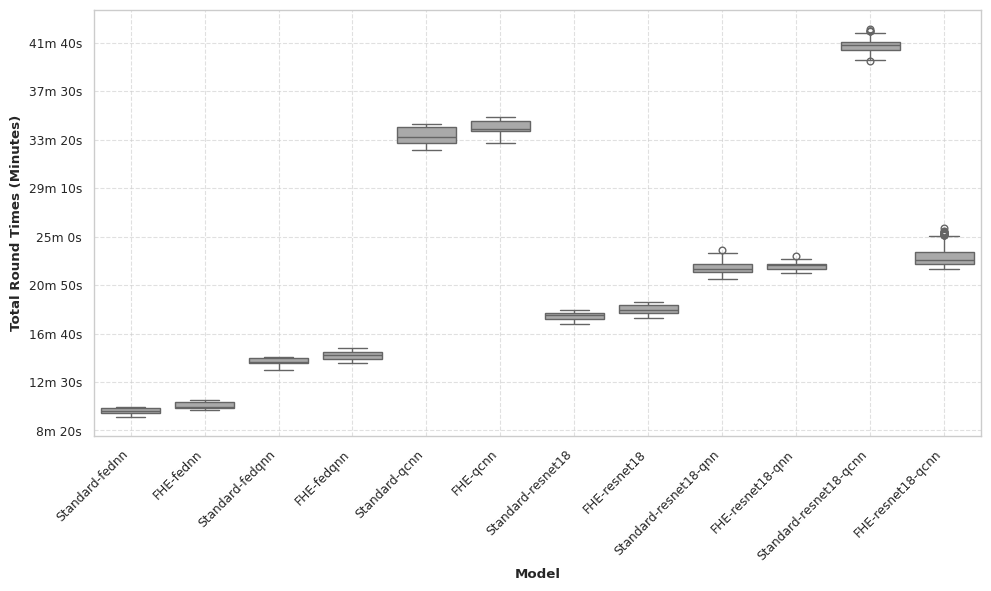

Model Total Round Times (Minutes)                       \
                                                 count       mean       std   
6           Standard-fednn                    1.666667  10.042793  0.227621   
0                FHE-fednn                    1.666667  10.464124  0.250768   
7          Standard-fedqnn                    1.666667  14.256723  0.268474   
1               FHE-fedqnn                    1.666667  14.725720  0.335946   
9        Standard-resnet18                    1.666667  18.162874  0.338306   
3             FHE-resnet18                    1.666667  18.731432  0.342975   
11   Standard-resnet18-qnn                    1.666667  22.307747  0.509249   
5         FHE-resnet18-qnn                    1.666667  22.488957  0.340155   
4        FHE-resnet18-qcnn                    1.666667  23.362951  0.972199   
8            Standard-qcnn                    1.666667  33.649009  0.763629   
2                 FHE-qcnn                    1.666667  34.386367  0.579580   
10  Standard-resnet18-qcnn                    1.666667  41.370287  0.637975   

                                                           
          min        25%        50%        75%        max  
6    9.507527   9.804808  10.017689  10.248815  10.357953  
0   10.122357  10.280817  10.359595  10.799868  10.950722  
7   13.490200  14.093551  14.202489  14.549571  14.666329  
1   14.158676  14.464546  14.801658  15.036865  15.383286  
9   17.482525  17.951248  18.220323  18.394247  18.720950  
3   17.962672  18.440515  18.677284  19.081555  19.379077  
11  21.336466  21.969167  22.212131  22.640861  23.842173  
5   21.884533  22.216422  22.582786  22.652284  23.338939  
4   22.243208  22.672487  22.949826  23.639610  25.733038  
8   32.456627  33.037717  33.559831  34.456550  34.675579  
2   33.033028  34.033413  34.208468  34.975974  35.276056  
10  40.100908  41.075732  41.482929  41.703531  42.828957

In [18]:
metric_label = "Total Round Times (Minutes)"
df = get_dataframe_from_metrics_data(round_times, metric_label)
display_boxplot(df, metric_label, format_time)
stats = (df.groupby("Model").describe() / 60).reset_index().sort_values((metric_label,  'mean'))
stats

## CPU Usage

In [19]:
client_cpu_usage = get_metric_by_model_type(runs, groups, "system_metric", "client_cpu_percentage")

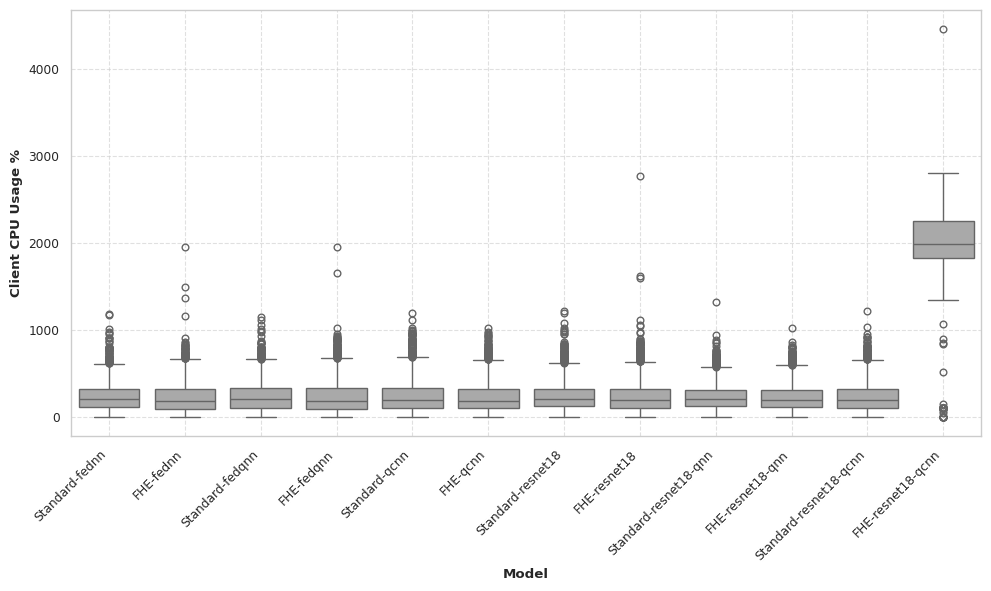

Client CPU Usage %                                \
                                    count         mean         std  min   
Model                                                                     
FHE-fednn                          2128.0   226.406720  178.920159  2.0   
FHE-fedqnn                         2245.0   231.604633  188.494019  2.0   
FHE-qcnn                           2406.0   233.067041  174.116054  1.9   
FHE-resnet18                       2314.0   236.478868  183.706731  2.0   
FHE-resnet18-qcnn                  2477.0  1998.570933  386.694861  2.0   
FHE-resnet18-qnn                   2363.0   229.696276  153.732896  2.0   
Standard-fednn                     2317.0   237.497799  155.341192  2.0   
Standard-fedqnn                    2320.0   238.425043  163.204979  2.0   
Standard-qcnn                      2407.0   241.730661  184.571732  2.0   
Standard-resnet18                  2312.0   239.754715  162.767732  2.0   
Standard-resnet18-qcnn             2424.0   235.943441  169.780465  2.0   
Standard-resnet18-qnn              2428.0   233.726194  141.982490  2.0   

                                                             
                             25%      50%       75%     max  
Model                                                        
FHE-fednn                 95.900   181.75   325.600  1949.8  
FHE-fedqnn                95.900   183.80   327.700  1949.9  
FHE-qcnn                  99.900   188.70   325.200  1018.9  
FHE-resnet18             105.900   195.80   317.700  2765.2  
FHE-resnet18-qcnn       1828.200  1984.10  2253.800  4458.8  
FHE-resnet18-qnn         111.800   193.80   307.700  1021.0  
Standard-fednn           119.900   203.80   317.700  1178.9  
Standard-fedqnn          107.325   201.65   331.700  1146.9  
Standard-qcnn             99.900   195.80   336.700  1190.9  
Standard-resnet18        121.900   205.80   321.325  1218.6  
Standard-resnet18-qcnn   103.900   195.80   326.200  1214.7  
Standard-resnet18-qnn    127.850   205.80   307.700  1322.6

In [20]:
metric_label = "Client CPU Usage %"
df = get_dataframe_from_metrics_data(client_cpu_usage, metric_label)
df = df[df[metric_label] > 0]
display_boxplot(df, metric_label)
df.groupby("Model").describe()

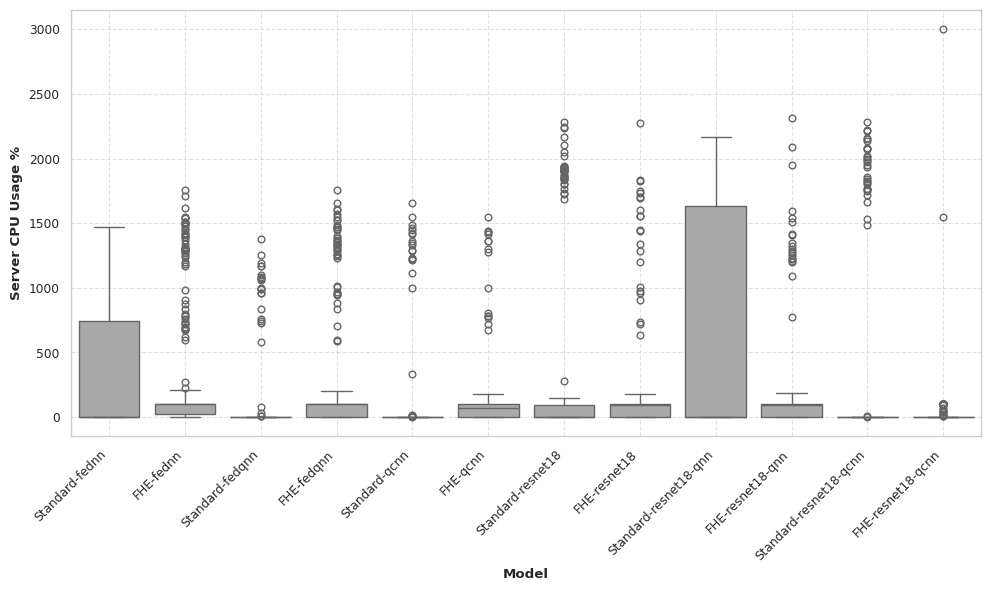

Server CPU Usage %                                     \
                                    count        mean         std  min   25%   
Model                                                                          
FHE-fednn                           469.0  191.789765  367.818512  2.0  22.0   
FHE-fedqnn                          387.0  184.883204  381.200007  2.0   2.0   
FHE-qcnn                            230.0  119.147391  278.510373  2.0   2.0   
FHE-resnet18                        320.0  148.470938  353.900428  1.9   2.0   
FHE-resnet18-qcnn                   171.0   40.533918  257.829936  2.0   2.0   
FHE-resnet18-qnn                    317.0  143.536909  345.218080  2.0   2.0   
Standard-fednn                      161.0  283.185093  462.259306  2.0   2.0   
Standard-fedqnn                     120.0  170.070833  383.038065  2.0   2.0   
Standard-qcnn                       136.0  181.256618  457.208669  1.9   2.0   
Standard-resnet18                   146.0  441.758219  807.685462  2.0   2.0   
Standard-resnet18-qcnn              125.0  448.145600  820.662399  1.4   2.0   
Standard-resnet18-qnn               146.0  509.221918  818.150597  2.0   2.0   

                                                
                          50%      75%     max  
Model                                           
FHE-fednn               97.90    99.90  1758.1  
FHE-fedqnn              97.90    99.90  1754.0  
FHE-qcnn                69.85    99.90  1544.6  
FHE-resnet18            89.90    99.90  2271.3  
FHE-resnet18-qcnn        2.00     2.00  3000.8  
FHE-resnet18-qnn        93.90    99.90  2315.6  
Standard-fednn           2.00   741.10  1470.5  
Standard-fedqnn          2.00     2.00  1376.7  
Standard-qcnn            2.00     2.00  1654.1  
Standard-resnet18        2.00    93.40  2279.5  
Standard-resnet18-qcnn   2.00     2.00  2280.1  
Standard-resnet18-qnn    2.00  1631.75  2167.8

In [21]:
server_cpu_usage = get_metric_by_model_type(runs, groups, "system_metric", "server_cpu_percentage")
metric_label = "Server CPU Usage %"
df = get_dataframe_from_metrics_data(server_cpu_usage, metric_label)
df = df[df[metric_label] > 0]
display_boxplot(df, metric_label)
df.groupby("Model").describe()

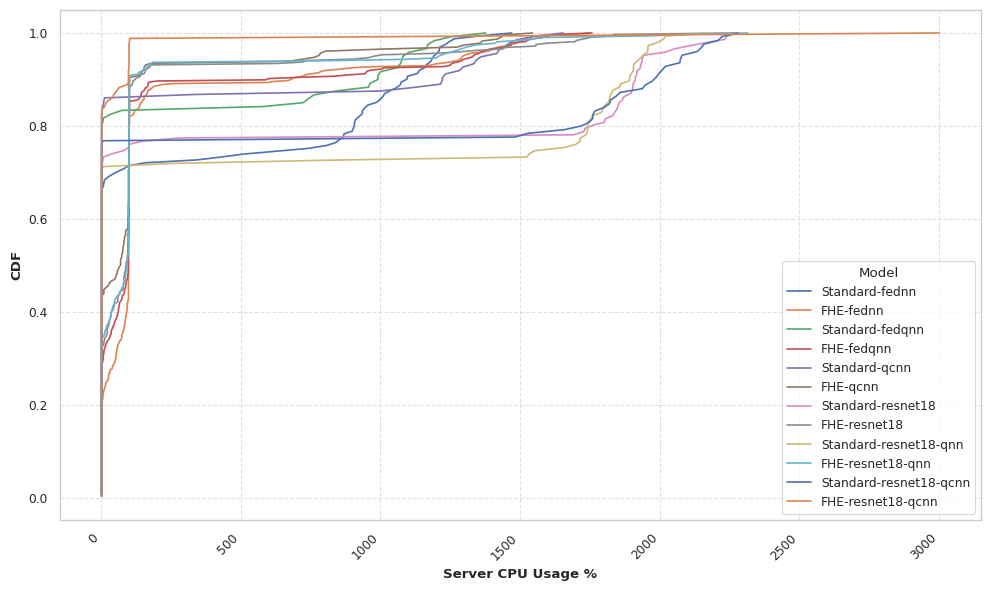

In [22]:
def display_cdf_plot(metrics_df: pd.DataFrame, metric_label: str):
    sns.set_theme(style="whitegrid", context="paper")
    
    fig, ax = plt.subplots(figsize=(10, 6))
    
    for model in metrics_df['Model'].unique():
        data = metrics_df[metrics_df['Model'] == model][metric_label]
        # Sort data for CDF calculation
        data_sorted = np.sort(data)
        cdf = np.arange(1, len(data_sorted) + 1) / len(data_sorted)
        ax.plot(data_sorted, cdf, label=model)
    
    plt.xticks(rotation=45, ha="right")
    plt.xlabel(metric_label, fontweight="bold")
    plt.ylabel("CDF", fontweight="bold")
    plt.grid(True, linestyle="--", alpha=0.6)
    
    ax.legend(title='Model')
    
    # Display the plot
    plt.tight_layout()
    plt.show()

# Example usage:
display_cdf_plot(df, metric_label)

# RAM Usage

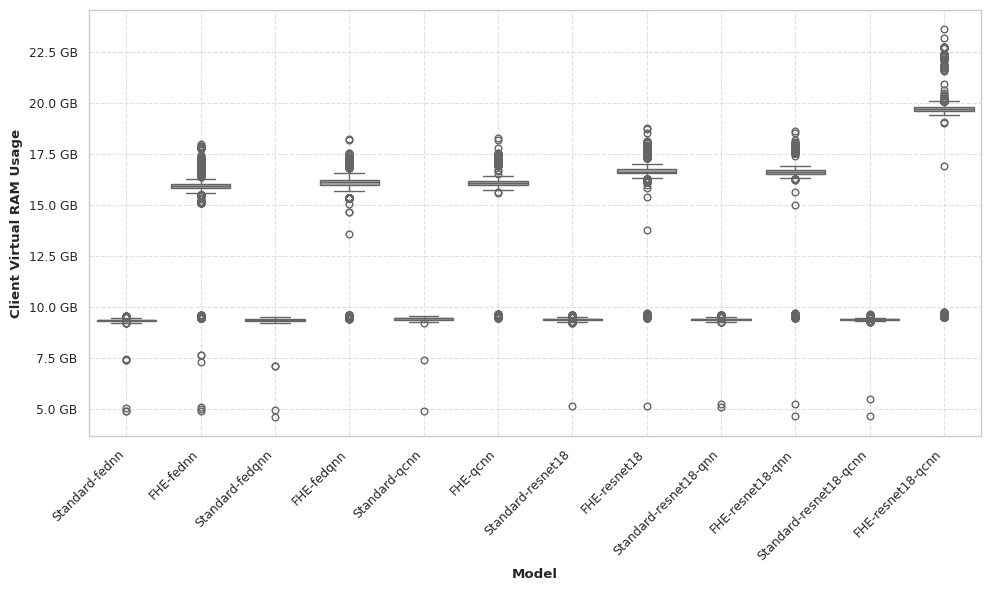

Client Virtual RAM Usage                             \
                                          count          mean          std   
Model                                                                        
FHE-fednn                                2438.0  15810.392139  1307.403905   
FHE-fedqnn                               2471.0  15919.863838  1449.284434   
FHE-qcnn                                 2498.0  15841.848429  1459.654752   
FHE-resnet18                             2489.0  16417.029769  1547.865386   
FHE-resnet18-qcnn                        2497.0  19336.803158  2164.554996   
FHE-resnet18-qnn                         2493.0  16338.896905  1579.325546   
Standard-fednn                           2457.0   9351.212956   177.431800   
Standard-fedqnn                          2492.0   9370.991444   157.992241   
Standard-qcnn                            2477.0   9427.784927   116.999734   
Standard-resnet18                        2495.0   9391.725057   100.334654   
Standard-resnet18-qcnn                   2498.0   9391.104520   130.663814   
Standard-resnet18-qnn                    2490.0   9389.933367   130.169101   

                                                                       \
                             min          25%         50%         75%   
Model                                                                   
FHE-fednn               4910.238  15840.69550  15943.0510  16034.5470   
FHE-fedqnn              9390.207  15974.18800  16130.0430  16249.8120   
FHE-qcnn                9450.840  15989.26375  16101.3400  16189.0770   
FHE-resnet18            5146.652  16586.74200  16645.6910  16766.4920   
FHE-resnet18-qcnn       9496.152  19612.97700  19708.8590  19803.4140   
FHE-resnet18-qnn        4643.688  16536.36300  16601.9180  16707.3750   
Standard-fednn          4911.562   9318.32000   9348.9020   9384.4020   
Standard-fedqnn         4610.074   9327.00400   9364.5430   9425.9150   
Standard-qcnn           4910.363   9379.30900   9448.8830   9481.4650   
Standard-resnet18       5157.543   9359.50200   9391.0780   9418.0740   
Standard-resnet18-qcnn  4654.199   9367.41050   9392.7770   9412.6360   
Standard-resnet18-qnn   5093.188   9357.49100   9390.6385   9417.0175   

                                   
                              max  
Model                              
FHE-fednn               17985.328  
FHE-fedqnn              18228.223  
FHE-qcnn                18297.727  
FHE-resnet18            18760.969  
FHE-resnet18-qcnn       23632.793  
FHE-resnet18-qnn        18637.949  
Standard-fednn           9545.387  
Standard-fedqnn          9523.758  
Standard-qcnn            9573.414  
Standard-resnet18        9613.668  
Standard-resnet18-qcnn   9636.809  
Standard-resnet18-qnn    9626.016

In [23]:
def format_usage(usage_mb, _):
    if usage_mb < 1_000:
        return f"{int(usage_mb)} MB"
    else:
        gb = round(usage_mb / 1_000, 2)
        return f"{gb} GB"
    
client_vir_ram_usage = get_metric_by_model_type(runs, groups, "system_metric", "client_virtual_memory_mb")
metric_label = "Client Virtual RAM Usage"
df = get_dataframe_from_metrics_data(client_vir_ram_usage, metric_label)

display_boxplot(df, metric_label, format_usage)
df.groupby("Model").describe()

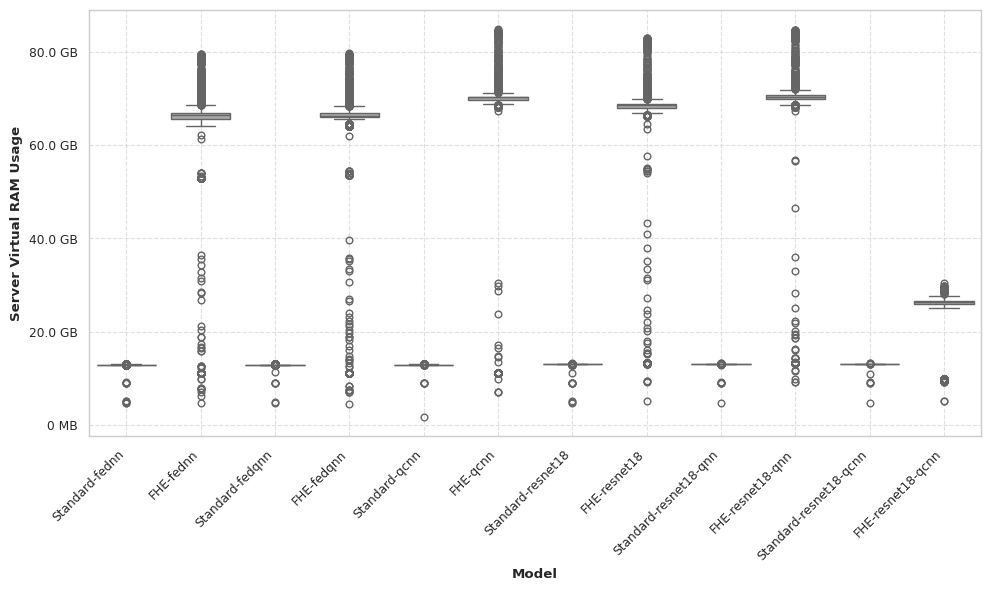

Server Virtual RAM Usage                              \
                                          count          mean           std   
Model                                                                         
FHE-fednn                                2449.0  64423.285989  12940.790256   
FHE-fedqnn                               2468.0  64397.183027  13031.822671   
FHE-qcnn                                 2500.0  67290.012538  14317.335202   
FHE-resnet18                             2494.0  67105.712509  11420.041194   
FHE-resnet18-qcnn                        2500.0  25676.808316   3662.961662   
FHE-resnet18-qnn                         2500.0  68151.178766  12859.698466   
Standard-fednn                           2437.0  12910.621551    411.590740   
Standard-fedqnn                          2423.0  12938.277608    285.411599   
Standard-qcnn                            2500.0  12939.250396    286.059938   
Standard-resnet18                        2415.0  13021.098543    359.080127   
Standard-resnet18-qcnn                   2500.0  13053.505214    221.810560   
Standard-resnet18-qnn                    2500.0  13045.421636    243.529189   

                                                                              
                             min        25%        50%        75%        max  
Model                                                                         
FHE-fednn               4785.656  65658.719  66372.645  66846.566  79573.785  
FHE-fedqnn              4573.566  66054.570  66314.727  66964.250  79639.738  
FHE-qcnn                7158.902  69709.488  70203.094  70311.332  84844.320  
FHE-resnet18            5084.156  67992.770  68502.480  68761.168  82921.242  
FHE-resnet18-qcnn       5114.695  25975.289  26423.293  26677.832  30516.680  
FHE-resnet18-qnn        9258.539  69815.867  70396.367  70653.562  84745.930  
Standard-fednn          4660.121  12919.430  12932.387  12954.457  13067.051  
Standard-fedqnn         4660.434  12951.418  12956.043  12956.996  13070.844  
Standard-qcnn           1758.812  12940.961  12953.758  12962.957  13048.898  
Standard-resnet18       4819.711  13027.297  13052.336  13055.039  13238.465  
Standard-resnet18-qcnn  4629.445  13047.598  13062.035  13078.133  13229.898  
Standard-resnet18-qnn   4701.820  13049.434  13060.910  13063.293  13221.953

In [24]:
server_vir_ram_usage = get_metric_by_model_type(runs, groups, "system_metric", "server_virtual_memory_mb")
metric_label = "Server Virtual RAM Usage"
df = get_dataframe_from_metrics_data(server_vir_ram_usage, metric_label)

display_boxplot(df, metric_label, format_usage)
df.groupby("Model").describe()

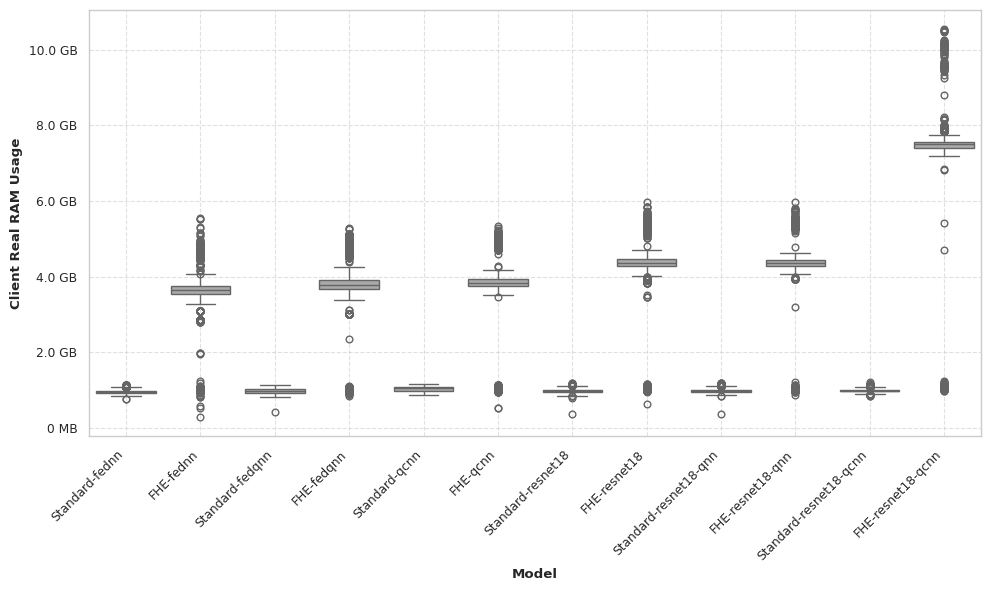

Client Real RAM Usage                            \
                                       count         mean          std   
Model                                                                    
FHE-fednn                             2442.0  3629.454064   696.314309   
FHE-fedqnn                            2469.0  3726.599081   724.958694   
FHE-qcnn                              2496.0  3766.004022   656.806942   
FHE-resnet18                          2488.0  4288.004733   769.713838   
FHE-resnet18-qcnn                     2496.0  7304.854405  1403.873907   
FHE-resnet18-qnn                      2494.0  4274.950800   781.920709   
Standard-fednn                        2450.0   950.337337    54.070873   
Standard-fedqnn                       2480.0   971.964269    62.135720   
Standard-qcnn                         2482.0  1032.367417    59.836356   
Standard-resnet18                     2494.0   975.230032    53.668820   
Standard-resnet18-qcnn                2499.0   987.191764    42.407563   
Standard-resnet18-qnn                 2498.0   978.639248    53.001436   

                                                                               
                            min         25%        50%         75%        max  
Model                                                                          
FHE-fednn               291.703  3544.52950  3650.6585  3752.70900   5547.137  
FHE-fedqnn              847.352  3657.77300  3774.6020  3895.75800   5277.180  
FHE-qcnn                524.871  3745.30000  3828.2815  3927.91825   5337.723  
FHE-resnet18            628.688  4277.38750  4347.8670  4468.05675   5982.195  
FHE-resnet18-qcnn       980.137  7383.74200  7491.3090  7563.25775  10537.363  
FHE-resnet18-qnn        874.863  4289.71975  4351.8885  4449.00700   5963.664  
Standard-fednn          752.863   911.63200   939.7540   974.64100   1143.637  
Standard-fedqnn         418.387   924.50125   962.5590  1018.35175   1143.727  
Standard-qcnn           880.727   985.65825  1049.6775  1082.03625   1159.805  
Standard-resnet18       359.422   939.05900   969.7695  1008.24925   1183.289  
Standard-resnet18-qcnn  853.363   960.80050   985.1800  1009.62150   1199.516  
Standard-resnet18-qnn   356.664   945.55825   973.7345  1006.08900   1186.715

In [25]:
client_real_ram_usage = get_metric_by_model_type(runs, groups, "system_metric", "client_real_memory_mb")
metric_label = "Client Real RAM Usage"
df = get_dataframe_from_metrics_data(client_real_ram_usage, metric_label)

display_boxplot(df, metric_label, format_usage)
df.groupby("Model").describe()

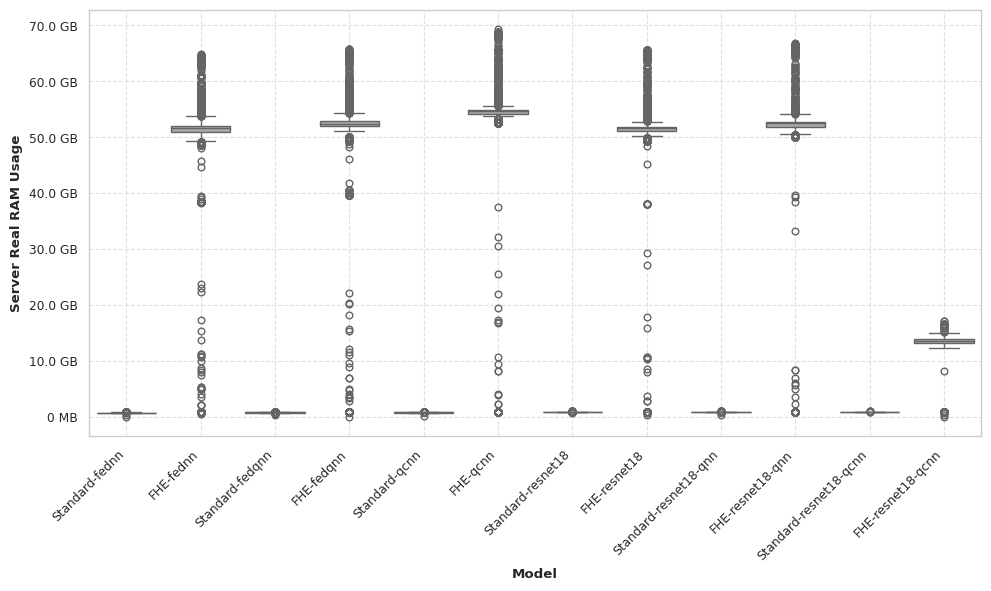

Server Real RAM Usage                              \
                                       count          mean           std   
Model                                                                      
FHE-fednn                             2436.0  50022.301440  11775.852371   
FHE-fedqnn                            2466.0  51015.606110  11333.760769   
FHE-qcnn                              2500.0  52521.043069  12209.963930   
FHE-resnet18                          2490.0  49708.346780  11720.734881   
FHE-resnet18-qcnn                     2500.0  13098.933085   2844.926412   
FHE-resnet18-qnn                      2500.0  50745.299377  11153.584660   
Standard-fednn                        2448.0    804.971047     25.757066   
Standard-fedqnn                       2434.0    824.654137     23.716441   
Standard-qcnn                         2500.0    824.265282     25.283487   
Standard-resnet18                     2415.0    906.443630     32.016074   
Standard-resnet18-qcnn                2500.0    927.162460     18.018405   
Standard-resnet18-qnn                 2500.0    920.052270     20.747405   

                                                                                
                            min          25%         50%        75%        max  
Model                                                                           
FHE-fednn               498.570  50938.65200  51731.8240  52076.637  64807.176  
FHE-fedqnn               83.000  52045.84000  52340.6720  52961.492  65745.812  
FHE-qcnn                884.848  54250.59000  54717.2070  54809.832  69326.562  
FHE-resnet18            406.320  51052.87500  51634.7380  51797.578  65653.824  
FHE-resnet18-qcnn        73.500  13240.84800  13687.2620  13959.492  17155.988  
FHE-resnet18-qnn        936.574  51809.53500  52620.0620  52727.309  66837.703  
Standard-fednn           52.066    788.27000    799.7340    820.312    898.164  
Standard-fedqnn         372.004    812.64425    827.6560    833.480    964.176  
Standard-qcnn           220.047    813.19650    824.5430    837.309    932.008  
Standard-resnet18       792.281    891.72300    910.7230    917.828   1101.910  
Standard-resnet18-qcnn  881.219    911.90200    930.0900    942.516   1050.500  
Standard-resnet18-qnn   412.438    910.03500    923.8695    931.348   1098.496

In [26]:
server_real_ram_usage = get_metric_by_model_type(runs, groups, "system_metric", "server_real_memory_mb")
metric_label = "Server Real RAM Usage"
df = get_dataframe_from_metrics_data(server_real_ram_usage, metric_label)
display_boxplot(df, metric_label, format_usage)
df.groupby("Model").describe()

# FHE

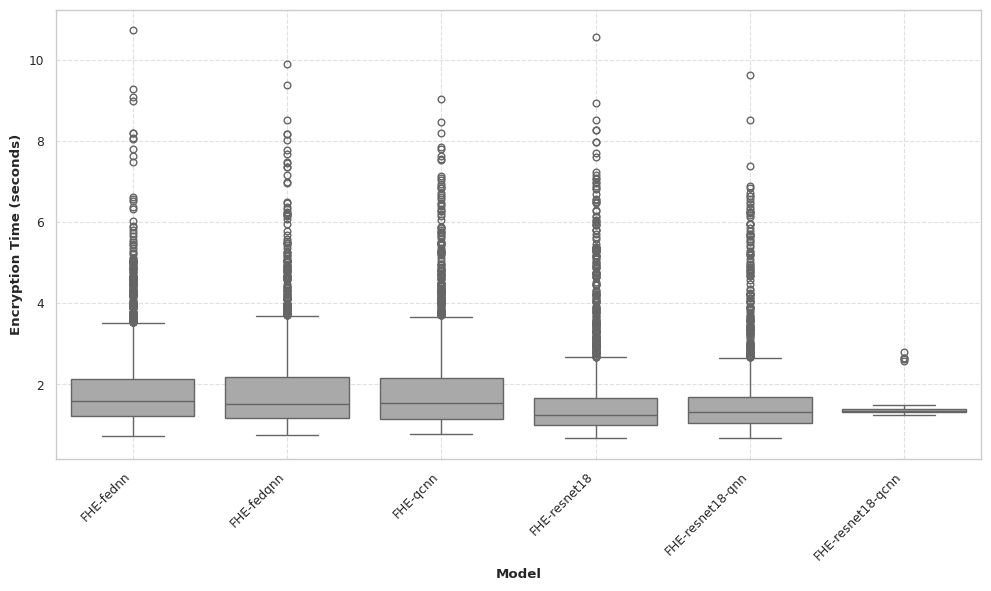

Encryption Time (seconds)                                \
                                      count      mean       std       min   
Model                                                                       
FHE-fednn                            2000.0  1.873207  1.053132  0.716592   
FHE-fedqnn                           2000.0  1.863797  1.087581  0.750992   
FHE-qcnn                             2000.0  1.874507  1.112628  0.775469   
FHE-resnet18                         2000.0  1.590038  1.116067  0.672745   
FHE-resnet18-qcnn                     100.0  1.408063  0.294673  1.246953   
FHE-resnet18-qnn                     2000.0  1.554495  0.940024  0.687920   

                                                            
                        25%       50%       75%        max  
Model                                                       
FHE-fednn          1.213804  1.593228  2.142175  10.733194  
FHE-fedqnn         1.169908  1.523361  2.178773   9.906615  
FHE-qcnn           1.144771  1.531817  2.158925   9.029217  
FHE-resnet18       0.987157  1.256004  1.658655  10.557287  
FHE-resnet18-qcnn  1.307043  1.337699  1.381020   2.803933  
FHE-resnet18-qnn   1.039481  1.309266  1.687874   9.634766

In [27]:
client_encryption_time = get_metric_by_model_type(runs, groups, "client_metric", "encryption_time")
metric_label = "Encryption Time (seconds)"
df = get_dataframe_from_metrics_data(client_encryption_time, metric_label)

display_boxplot(df, metric_label)
df.groupby("Model").describe()

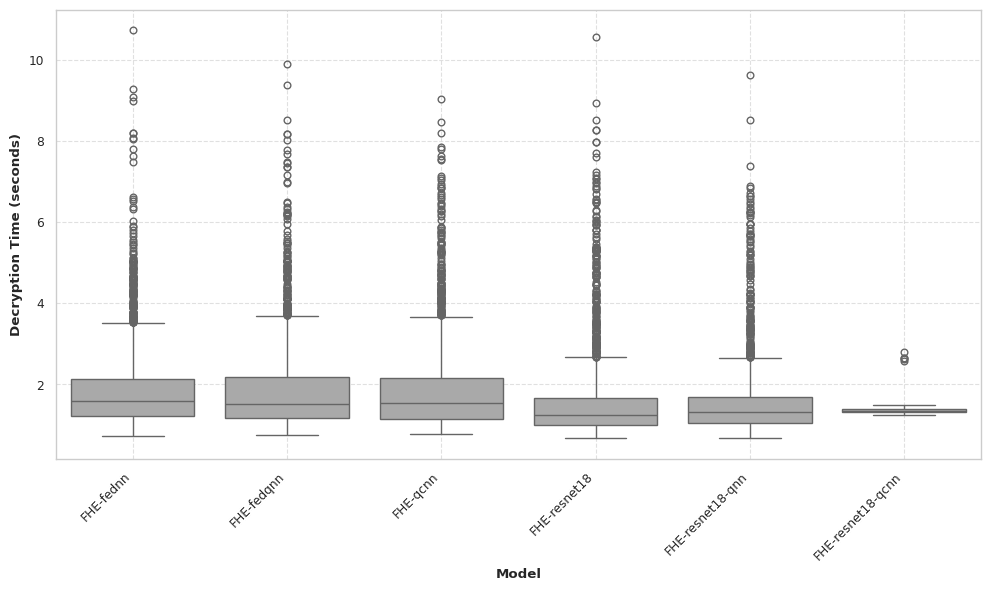

Decryption Time (seconds)                                \
                                      count      mean       std       min   
Model                                                                       
FHE-fednn                            2000.0  1.873207  1.053132  0.716592   
FHE-fedqnn                           2000.0  1.863797  1.087581  0.750992   
FHE-qcnn                             2000.0  1.874507  1.112628  0.775469   
FHE-resnet18                         2000.0  1.590038  1.116067  0.672745   
FHE-resnet18-qcnn                     100.0  1.408063  0.294673  1.246953   
FHE-resnet18-qnn                     2000.0  1.554495  0.940024  0.687920   

                                                            
                        25%       50%       75%        max  
Model                                                       
FHE-fednn          1.213804  1.593228  2.142175  10.733194  
FHE-fedqnn         1.169908  1.523361  2.178773   9.906615  
FHE-qcnn           1.144771  1.531817  2.158925   9.029217  
FHE-resnet18       0.987157  1.256004  1.658655  10.557287  
FHE-resnet18-qcnn  1.307043  1.337699  1.381020   2.803933  
FHE-resnet18-qnn   1.039481  1.309266  1.687874   9.634766

In [28]:
client_decryption_time = get_metric_by_model_type(runs, groups, "client_metric", "decryption_time")
metric_label = "Decryption Time (seconds)"
df = get_dataframe_from_metrics_data(client_encryption_time, metric_label)

display_boxplot(df, metric_label)
df.groupby("Model").describe()

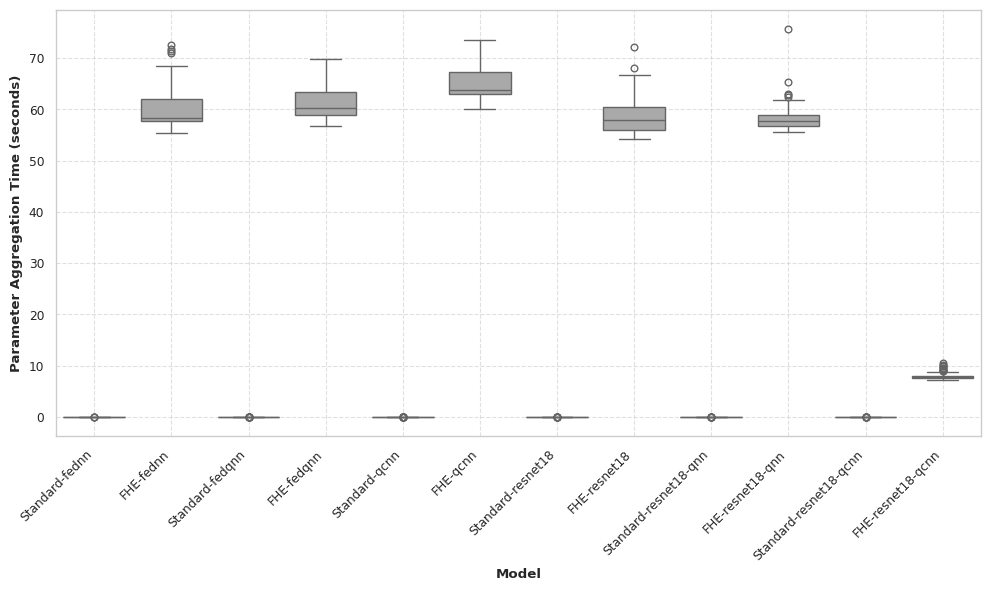

Parameter Aggregation Time (seconds)             \
                                                      count       mean   
Model                                                                    
FHE-fednn                                             100.0  59.790676   
FHE-fedqnn                                            100.0  61.168137   
FHE-qcnn                                              100.0  64.833991   
FHE-resnet18                                          100.0  58.707018   
FHE-resnet18-qcnn                                     100.0   7.907789   
FHE-resnet18-qnn                                      100.0  58.268315   
Standard-fednn                                        100.0   0.025263   
Standard-fedqnn                                       100.0   0.034403   
Standard-qcnn                                         100.0   0.034711   
Standard-resnet18                                     100.0   0.006675   
Standard-resnet18-qcnn                                100.0   0.015985   
Standard-resnet18-qnn                                 100.0   0.015896   

                                                                              \
                             std        min        25%        50%        75%   
Model                                                                          
FHE-fednn               3.686657  55.427822  57.701411  58.356875  62.078650   
FHE-fedqnn              3.005746  56.826933  58.980760  60.186729  63.426057   
FHE-qcnn                3.025415  60.053301  63.027990  63.736184  67.362918   
FHE-resnet18            3.595246  54.226566  55.933147  57.970505  60.534344   
FHE-resnet18-qcnn       0.636266   7.281575   7.537316   7.753109   8.004150   
FHE-resnet18-qnn        2.538673  55.592551  56.713159  57.686546  58.946140   
Standard-fednn          0.000693   0.024445   0.024848   0.025023   0.025514   
Standard-fedqnn         0.001151   0.033249   0.033799   0.034076   0.034582   
Standard-qcnn           0.001183   0.033573   0.034013   0.034377   0.034813   
Standard-resnet18       0.000187   0.006416   0.006583   0.006627   0.006706   
Standard-resnet18-qcnn  0.000219   0.015685   0.015853   0.015935   0.016027   
Standard-resnet18-qnn   0.000311   0.015483   0.015688   0.015823   0.016001   

                                   
                              max  
Model                              
FHE-fednn               72.595167  
FHE-fedqnn              69.732001  
FHE-qcnn                73.447276  
FHE-resnet18            72.099207  
FHE-resnet18-qcnn       10.574440  
FHE-resnet18-qnn        75.647678  
Standard-fednn           0.028986  
Standard-fedqnn          0.042843  
Standard-qcnn            0.040678  
Standard-resnet18        0.007984  
Standard-resnet18-qcnn   0.016755  
Standard-resnet18-qnn    0.017221

In [29]:
server_aggregation_time = get_metric_by_model_type(runs, groups, "server_metric", "parameter_aggregation_time")
metric_label = "Parameter Aggregation Time (seconds)"
df = get_dataframe_from_metrics_data(server_aggregation_time, metric_label)

display_boxplot(df, metric_label)
df.groupby("Model").describe()

# Communication Overhead

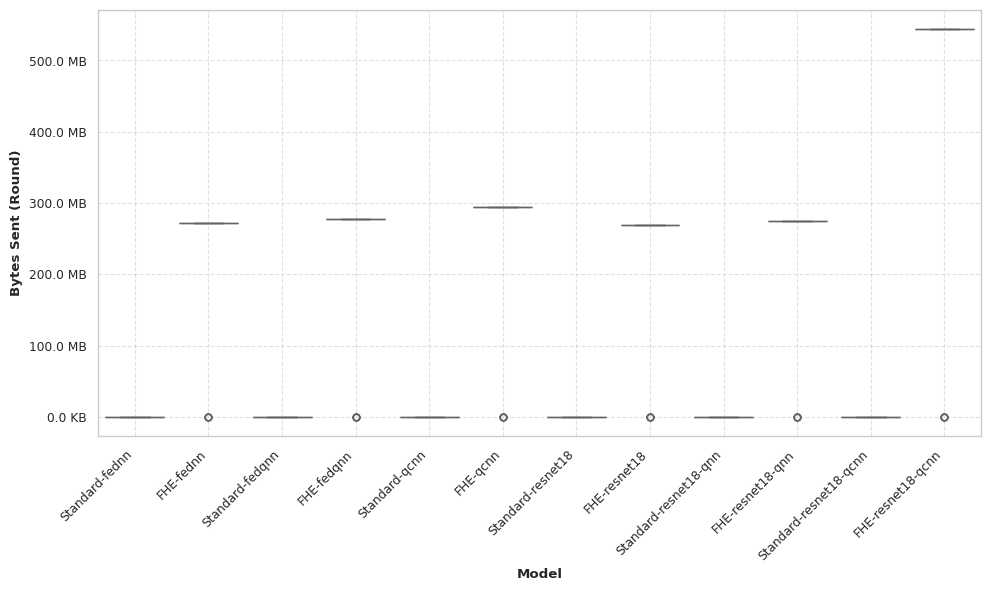

Bytes Sent (Round)                              \
                                    count          mean           std   
Model                                                                   
FHE-fednn                           100.0  2.577641e+08  5.943088e+07   
FHE-fedqnn                          100.0  2.632485e+08  6.069529e+07   
FHE-qcnn                            100.0  2.793276e+08  6.440255e+07   
FHE-resnet18                        100.0  2.557696e+08  5.897121e+07   
FHE-resnet18-qcnn                   100.0  5.166496e+08  1.191207e+08   
FHE-resnet18-qnn                    100.0  2.612541e+08  6.023563e+07   
Standard-fednn                      100.0  9.435000e+03  0.000000e+00   
Standard-fedqnn                     100.0  1.000400e+04  0.000000e+00   
Standard-qcnn                       100.0  1.052000e+04  0.000000e+00   
Standard-resnet18                   100.0  8.573000e+03  0.000000e+00   
Standard-resnet18-qcnn              100.0  1.733800e+04  0.000000e+00   
Standard-resnet18-qnn               100.0  9.142000e+03  0.000000e+00   

                                                                        \
                            min          25%          50%          75%   
Model                                                                    
FHE-fednn                9435.0  271330133.0  271330133.0  271330133.0   
FHE-fedqnn              10004.0  277103165.0  277103165.0  277103165.0   
FHE-qcnn                10520.0  294028480.0  294028480.0  294028480.0   
FHE-resnet18             8573.0  269230755.0  269230755.0  269230755.0   
FHE-resnet18-qcnn       17338.0  543840782.0  543840782.0  543840782.0   
FHE-resnet18-qnn         9142.0  275003787.0  275003787.0  275003787.0   
Standard-fednn           9435.0       9435.0       9435.0       9435.0   
Standard-fedqnn         10004.0      10004.0      10004.0      10004.0   
Standard-qcnn           10520.0      10520.0      10520.0      10520.0   
Standard-resnet18        8573.0       8573.0       8573.0       8573.0   
Standard-resnet18-qcnn  17338.0      17338.0      17338.0      17338.0   
Standard-resnet18-qnn    9142.0       9142.0       9142.0       9142.0   

                                     
                                max  
Model                                
FHE-fednn               271330133.0  
FHE-fedqnn              277103165.0  
FHE-qcnn                294028480.0  
FHE-resnet18            269230755.0  
FHE-resnet18-qcnn       543840782.0  
FHE-resnet18-qnn        275003787.0  
Standard-fednn               9435.0  
Standard-fedqnn             10004.0  
Standard-qcnn               10520.0  
Standard-resnet18            8573.0  
Standard-resnet18-qcnn      17338.0  
Standard-resnet18-qnn        9142.0

In [30]:
def format_bytes(bytes, _):
    if bytes < 1_000_000:
        value = round(int(bytes) * 0.001, 2)
        return f"{value} KB"
    if bytes < 1_000_000_000:
        value = round(int(bytes) * 0.000001, 2)
        return f"{value} MB"
    else:
        value = round(int(bytes) * 1e-9, 2)
        return f"{value} GB"
    
server_bytes_sent = get_metric_by_model_type(runs, groups, "server_metric", "Bytes Sent (Round)")
metric_label = "Bytes Sent (Round)"
df = get_dataframe_from_metrics_data(server_bytes_sent, metric_label)

display_boxplot(df, metric_label, format_bytes)
df.groupby("Model").describe()

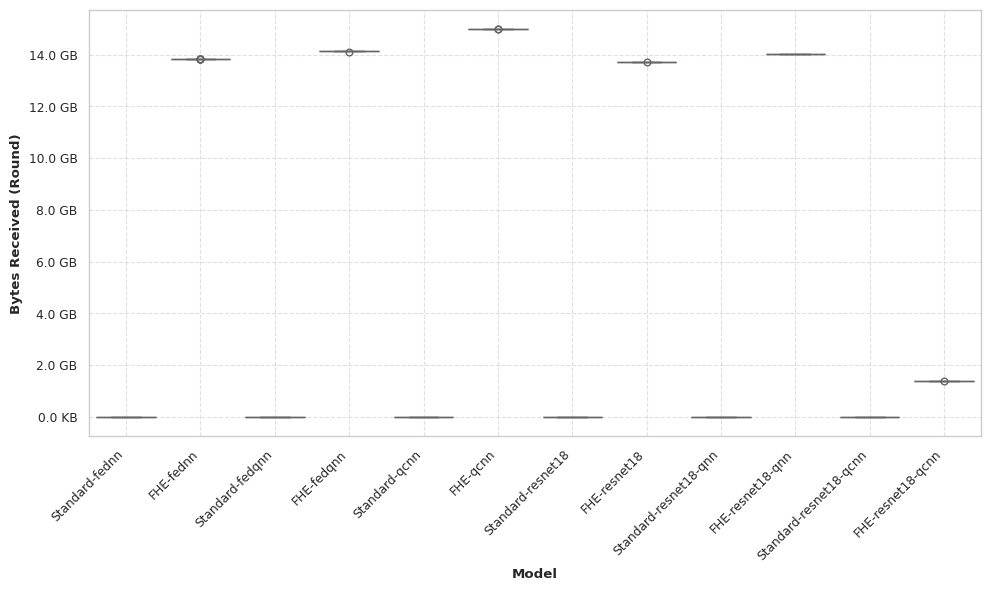

Bytes Received (Round)                              \
                                        count          mean           std   
Model                                                                       
FHE-fednn                               100.0  1.382569e+10  36938.063433   
FHE-fedqnn                              100.0  1.411986e+10  38749.213359   
FHE-qcnn                                100.0  1.498229e+10  44029.084480   
FHE-resnet18                            100.0  1.371872e+10  42268.551286   
FHE-resnet18-qcnn                       100.0  1.385579e+09  11847.282711   
FHE-resnet18-qnn                        100.0  1.401289e+10  39523.675248   
Standard-fednn                          100.0  1.887000e+05      0.000000   
Standard-fedqnn                         100.0  2.000800e+05      0.000000   
Standard-qcnn                           100.0  2.104000e+05      0.000000   
Standard-resnet18                       100.0  1.714600e+05      0.000000   
Standard-resnet18-qcnn                  100.0  3.467600e+05      0.000000   
Standard-resnet18-qnn                   100.0  1.828400e+05      0.000000   

                                                                  \
                                 min           25%           50%   
Model                                                              
FHE-fednn               1.382558e+10  1.382567e+10  1.382569e+10   
FHE-fedqnn              1.411972e+10  1.411984e+10  1.411986e+10   
FHE-qcnn                1.498215e+10  1.498226e+10  1.498229e+10   
FHE-resnet18            1.371864e+10  1.371869e+10  1.371872e+10   
FHE-resnet18-qcnn       1.385549e+09  1.385570e+09  1.385578e+09   
FHE-resnet18-qnn        1.401281e+10  1.401285e+10  1.401289e+10   
Standard-fednn          1.887000e+05  1.887000e+05  1.887000e+05   
Standard-fedqnn         2.000800e+05  2.000800e+05  2.000800e+05   
Standard-qcnn           2.104000e+05  2.104000e+05  2.104000e+05   
Standard-resnet18       1.714600e+05  1.714600e+05  1.714600e+05   
Standard-resnet18-qcnn  3.467600e+05  3.467600e+05  3.467600e+05   
Standard-resnet18-qnn   1.828400e+05  1.828400e+05  1.828400e+05   

                                                    
                                 75%           max  
Model                                               
FHE-fednn               1.382571e+10  1.382578e+10  
FHE-fedqnn              1.411989e+10  1.411995e+10  
FHE-qcnn                1.498232e+10  1.498238e+10  
FHE-resnet18            1.371875e+10  1.371885e+10  
FHE-resnet18-qcnn       1.385586e+09  1.385613e+09  
FHE-resnet18-qnn        1.401292e+10  1.401299e+10  
Standard-fednn          1.887000e+05  1.887000e+05  
Standard-fedqnn         2.000800e+05  2.000800e+05  
Standard-qcnn           2.104000e+05  2.104000e+05  
Standard-resnet18       1.714600e+05  1.714600e+05  
Standard-resnet18-qcnn  3.467600e+05  3.467600e+05  
Standard-resnet18-qnn   1.828400e+05  1.828400e+05

In [31]:
server_bytes_received = get_metric_by_model_type(runs, groups, "server_metric", "Bytes Received (Round)")
metric_label = "Bytes Received (Round)"
df = get_dataframe_from_metrics_data(server_bytes_received, metric_label)

display_boxplot(df, metric_label, format_bytes)
df.groupby("Model").describe()

In [32]:
server_total_bytes_sent = get_metric_by_model_type(runs, groups, "server_metric", "Total Bytes Sent")
metric_label = "Total Bytes Sent"
df = get_dataframe_from_metrics_data(server_total_bytes_sent, metric_label)

for model in KEY_ORDER:
    print(f"{model}: {format_bytes(max(df[df["Model"] == model]["Total Bytes Sent"]), _)}")

df.groupby("Model").describe()

Standard-fednn: 188.7 KB
FHE-fednn: 5.16 GB
Standard-fedqnn: 200.08 KB
FHE-fedqnn: 5.26 GB
Standard-qcnn: 210.4 KB
FHE-qcnn: 5.59 GB
Standard-resnet18: 171.46 KB
FHE-resnet18: 5.12 GB
Standard-resnet18-qnn: 182.84 KB
FHE-resnet18-qnn: 5.23 GB
Standard-resnet18-qcnn: 346.76 KB
FHE-resnet18-qcnn: 10.33 GB


Total Bytes Sent                                       \
                                  count          mean           std      min   
Model                                                                          
FHE-fednn                         100.0  2.577646e+09  1.572448e+09   9435.0   
FHE-fedqnn                        100.0  2.632490e+09  1.605904e+09  10004.0   
FHE-qcnn                          100.0  2.793281e+09  1.703992e+09  10520.0   
FHE-resnet18                      100.0  2.557701e+09  1.560281e+09   8573.0   
FHE-resnet18-qcnn                 100.0  5.166505e+09  3.151737e+09  17338.0   
FHE-resnet18-qnn                  100.0  2.612545e+09  1.593738e+09   9142.0   
Standard-fednn                    100.0  9.906750e+04  5.467895e+04   9435.0   
Standard-fedqnn                   100.0  1.050420e+05  5.797649e+04  10004.0   
Standard-qcnn                     100.0  1.104600e+05  6.096688e+04  10520.0   
Standard-resnet18                 100.0  9.001650e+04  4.968337e+04   8573.0   
Standard-resnet18-qcnn            100.0  1.820490e+05  1.004794e+05  17338.0   
Standard-resnet18-qnn             100.0  9.599100e+04  5.298091e+04   9142.0   

                                                                                
                                 25%           50%           75%           max  
Model                                                                           
FHE-fednn               1.288828e+09  2.577646e+09  3.866464e+09  5.155282e+09  
FHE-fedqnn              1.316250e+09  2.632490e+09  3.948730e+09  5.264970e+09  
FHE-qcnn                1.396646e+09  2.793281e+09  4.189916e+09  5.586552e+09  
FHE-resnet18            1.278855e+09  2.557701e+09  3.836547e+09  5.115393e+09  
FHE-resnet18-qcnn       2.583261e+09  5.166505e+09  7.749748e+09  1.033299e+10  
FHE-resnet18-qnn        1.306277e+09  2.612545e+09  3.918813e+09  5.225081e+09  
Standard-fednn          5.425125e+04  9.906750e+04  1.438838e+05  1.887000e+05  
Standard-fedqnn         5.752300e+04  1.050420e+05  1.525610e+05  2.000800e+05  
Standard-qcnn           6.049000e+04  1.104600e+05  1.604300e+05  2.104000e+05  
Standard-resnet18       4.929475e+04  9.001650e+04  1.307382e+05  1.714600e+05  
Standard-resnet18-qcnn  9.969350e+04  1.820490e+05  2.644045e+05  3.467600e+05  
Standard-resnet18-qnn   5.256650e+04  9.599100e+04  1.394155e+05  1.828400e+05

In [33]:
server_total_bytes_received = get_metric_by_model_type(runs, groups, "server_metric", "Total Bytes Received")
metric_label = "Total Bytes Received"
df = get_dataframe_from_metrics_data(server_total_bytes_received, metric_label)

for model in KEY_ORDER:
    print(f"{model}: {format_bytes(max(df[df["Model"] == model]["Total Bytes Received"]), _)}")

df.groupby("Model").describe()

Standard-fednn: 3.77 MB
FHE-fednn: 276.51 GB
Standard-fedqnn: 4.0 MB
FHE-fedqnn: 282.4 GB
Standard-qcnn: 4.21 MB
FHE-qcnn: 299.65 GB
Standard-resnet18: 3.43 MB
FHE-resnet18: 274.37 GB
Standard-resnet18-qnn: 3.66 MB
FHE-resnet18-qnn: 280.26 GB
Standard-resnet18-qcnn: 6.94 MB
FHE-resnet18-qcnn: 27.71 GB


Total Bytes Received                              \
                                      count          mean           std   
Model                                                                     
FHE-fednn                             100.0  1.451698e+11  8.012447e+10   
FHE-fedqnn                            100.0  1.482586e+11  8.182926e+10   
FHE-qcnn                              100.0  1.573141e+11  8.682732e+10   
FHE-resnet18                          100.0  1.440466e+11  7.950452e+10   
FHE-resnet18-qcnn                     100.0  1.454858e+10  8.029886e+09   
FHE-resnet18-qnn                      100.0  1.471353e+11  8.120931e+10   
Standard-fednn                        100.0  1.981350e+06  1.093579e+06   
Standard-fedqnn                       100.0  2.100840e+06  1.159530e+06   
Standard-qcnn                         100.0  2.209200e+06  1.219338e+06   
Standard-resnet18                     100.0  1.800330e+06  9.936674e+05   
Standard-resnet18-qcnn                100.0  3.640980e+06  2.009589e+06   
Standard-resnet18-qnn                 100.0  1.919820e+06  1.059618e+06   

                                                                  \
                                 min           25%           50%   
Model                                                              
FHE-fednn               1.382567e+10  7.949762e+10  1.451698e+11   
FHE-fedqnn              1.411983e+10  8.118921e+10  1.482586e+11   
FHE-qcnn                1.498226e+10  8.614819e+10  1.573141e+11   
FHE-resnet18            1.371871e+10  7.888257e+10  1.440466e+11   
FHE-resnet18-qcnn       1.385560e+09  7.967076e+09  1.454859e+10   
FHE-resnet18-qnn        1.401286e+10  8.057405e+10  1.471353e+11   
Standard-fednn          1.887000e+05  1.085025e+06  1.981350e+06   
Standard-fedqnn         2.000800e+05  1.150460e+06  2.100840e+06   
Standard-qcnn           2.104000e+05  1.209800e+06  2.209200e+06   
Standard-resnet18       1.714600e+05  9.858950e+05  1.800330e+06   
Standard-resnet18-qcnn  3.467600e+05  1.993870e+06  3.640980e+06   
Standard-resnet18-qnn   1.828400e+05  1.051330e+06  1.919820e+06   

                                                    
                                 75%           max  
Model                                               
FHE-fednn               2.108419e+11  2.765141e+11  
FHE-fedqnn              2.153280e+11  2.823973e+11  
FHE-qcnn                2.284800e+11  2.996459e+11  
FHE-resnet18            2.092106e+11  2.743745e+11  
FHE-resnet18-qcnn       2.113009e+10  2.771161e+10  
FHE-resnet18-qnn        2.136966e+11  2.802579e+11  
Standard-fednn          2.877675e+06  3.774000e+06  
Standard-fedqnn         3.051220e+06  4.001600e+06  
Standard-qcnn           3.208600e+06  4.208000e+06  
Standard-resnet18       2.614765e+06  3.429200e+06  
Standard-resnet18-qcnn  5.288090e+06  6.935200e+06  
Standard-resnet18-qnn   2.788310e+06  3.656800e+06